# Problem: Predict future PM2.5 values using historical real time data

In [8]:
#Import modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras import models
from keras import layers
from keras import regularizers
from keras.utils.np_utils import to_categorical
from sklearn import ensemble

## Section 1. Data Prep

In [9]:
##Load the data and Convert into Numpy arrays (avoid converting into pandas dataframe)
data_dir = 'D:\MSc2\Deep Learning Keras\Task4'
fname = os.path.join(data_dir, 'Data.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:len(lines)-1]

#print(header) #['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']
#print(len(lines)) #41757 timesteps (per hour)

In [10]:
#Target - PM2.5 value
y = np.zeros((len(lines),))

for i, line in enumerate(lines):
    #value = float(line.split(',')[5])
    value = float(line.split(',')[5])
    y[i] = value
    
#y.shape (41757,)

In [11]:
#Float features
x1 = np.zeros((len(lines),6))

for i, line in enumerate(lines):
    values = [float(x) for x in (line.split(',')[6:9] + line.split(',')[10:])]
    x1[i, :] = values
    
#x1.shape (41757, 6)

In [12]:
#Categorial features - One Hot Encoding
x2 = [None] * len(lines)

for i, line in enumerate(lines):
    value = line.split(',')[9]
    x2[i] = value
    
x2 = pd.Series(x2).astype("category")
d = dict(zip(x2.unique(), range(0,4))) 
x2 = x2.map(d, na_action='ignore') #map the labels of x2
x2 = np.asarray(x2).astype('object')
x2 = to_categorical(x2) #{'SE': 0, 'cv': 1, 'NW': 2, 'NE': 3}

In [13]:
#Concatenate all features into a single tensor
x = np.concatenate((x1, x2), axis=1)
#x.shape (41757, 10)

## Section 2. Data Visualization 

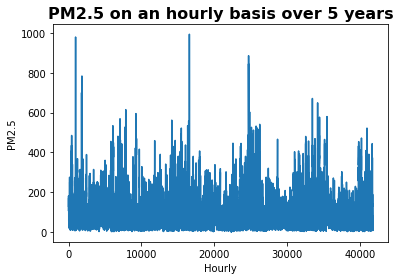

In [529]:
## whole dataset: (hourly basis over 5 years)  - Decreasing overall trend
plt.plot(range(len(y)), y) 
plt.xlabel('Hourly')
plt.ylabel('PM2.5')
plt.title('PM2.5 on an hourly basis over 5 years',fontweight='bold',fontsize=16)
plt.show()

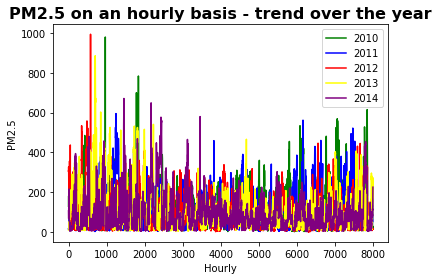

In [167]:
#Annual basis - High in spring, Low in summer/fall, Medium in winter (Seasonality)
###############Also decreasing overall trend over the years
t = [i for i in range(8000)]
y1,y2,y3,y4,y5 = y[:8000],y[8000:8000*2],y[8000*2:8000*3],y[8000*3:8000*4],y[8000*4:8000*5]
plt.plot(t,y1,color = 'green',label = '2010')
plt.plot(t,y2,color = 'blue',label = '2011')
plt.plot(t,y3,color = 'red',label = '2012')
plt.plot(t,y4,color = 'yellow',label = '2013')
plt.plot(t,y5,color = 'purple',label = '2014')
plt.xlabel('Hourly')
plt.ylabel('PM2.5')
plt.legend(loc='upper right')
plt.title('PM2.5 on an hourly basis - trend over the year',fontweight='bold',fontsize=16)
plt.show()

Text(0, 0.5, 'Density')

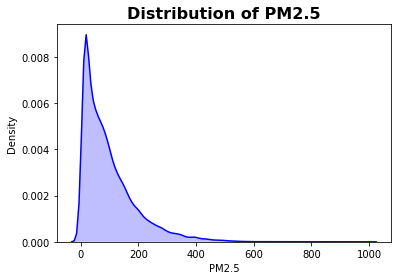

In [168]:
#Distribution of the target (PM2.5) - Fat tailed distribution
#q99 = np.quantile(y,0.99)
#yplot = y[y < q99]
ax = sns.kdeplot(y, shade=True, color="blue")
ax.set_title('Distribution of PM2.5', fontsize = 16, fontweight = 'bold')
ax.set_xlabel('PM2.5')
ax.set_ylabel('Density')
#mode around 10-15 
#np.mean(y),np.median(y) #(98.61321455085375, 72.0) - right skewed/fat-tail as mean > median

In [169]:
#Check correlation between (numerical) features using a heat map
feature = pd.DataFrame(x1)
feature.columns = ['Dew Point','Temp','Pres','Wind Speed',
                   'Snow','Rain']

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text xticklabel objects>)

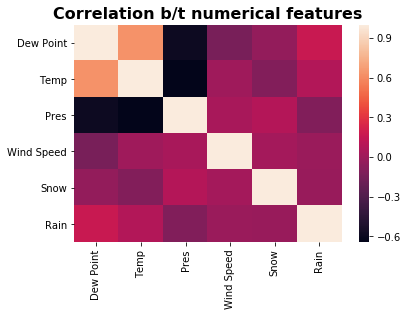

In [170]:
ax = sns.heatmap(feature.corr(method = 'kendall'))
ax.set_title('Correlation b/t numerical features', fontsize = 16, fontweight = 'bold')
plt.xticks(rotation=90)
#Note:overall no significant correlation b/t numerical features

In [171]:
##Check distribution of the features
#Plot all 16 Feature distribution
#platte = ["silver","rosybrown","firebrick","sienna","sandybrown","tan"]
#f = plt.figure(figsize=(10,10))
#for i in range(0,6): 
#    plt.subplot(6, 1, i+1)
#    sns.distplot(feature.iloc[:,i],color=platte[i])
#    plt.title(feature.columns.values[i])

## Section 3. Data standardization & Generators

In [14]:
##Prepare the data - Standardization & Generators
y = np.reshape(y, (y.shape[0],1))
float_data = np.concatenate((y, x), axis=1) #whole data - sequential data

#training data = 3 years    validation data = 1 year    test data = 1 year
q1 = 24418
q2 = 33096

#Then perform data standardizations
mean = float_data[:q1].mean(axis=0) #each feature has mean 0 and std 1 - mean = 97.8234499 and std = 89.24745025 for PM2.5
std = float_data[:q1].std(axis=0)
float_data = (float_data - mean)/std

#Note: scale the test and validation data using quantities from the training data 
#to prevent information flow into the future (validation/test data = future/unseen data) 

#float_data.shape - (41757, 11)

In [15]:
##Use generator to fit models
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices] #variables (including previous targets as for TS data)
            targets[j] = data[rows[j] + delay][0] #target - PM2.5 
        yield samples, targets

In [16]:
##Training, Validation, Test data generators
lookback = 2160 #observations go back 3 months - as periodicity seems to be season related
step = 6 #sample every 6 hours (data)
delay = 24 #predictions will be 1 day later in the future
batch_size = 128 #128 samples per batch

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=q1, 
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=q1+1, 
                    max_index=q2,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=q2+1, #test set
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

train_gen2 = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=q2-lookback, 
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (q2 - (q1 + 1)-  lookback) // batch_size 

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - (q2+1) - lookback) // batch_size 
#test_steps = (len(float_data) - (q2+1))// batch_size 

In [17]:
#true = [] #actual PM2.5 values (from test set)
#for i in range(test_steps):
#    true = true + list(next(test_gen)[1] * std[0] + mean[0])
ind = 6400
true = y[len(y)-ind:]
true = np.reshape(true, (true.shape[0],1))

In [18]:
#Daily PM2.5 (avg over 24 hours)
def DAY_AVG(val):
    T = 24   
    N = len(val) // T
    OUTPUT = []    
    for i in range(N):
        BLOCK = val[i*T:(i+1)*T]
        OUTPUT = OUTPUT + [sum(BLOCK)/T]
    return OUTPUT

## Section 4. Baseline Models

### Baseline 1. Gradient boosting

In [515]:
params = {'n_estimators': 1000,'learning_rate':0.1}
model_tree = ensemble.GradientBoostingRegressor(**params)

train_x,test_x = x[:len(float_data)-ind],x[len(float_data)-ind:]

y2 = np.reshape(y, (y.shape[0],))
train_y,test_y = y2[:len(float_data)-ind],y2[len(float_data)-ind:]

model_tree.fit(train_x,train_y)
predictions_tree = model_tree.predict(test_x)
predictions_tree = np.maximum(predictions_tree, np.zeros((predictions_tree.shape[0],))) #all PM2.5 values > 0

In [ ]:
#Predicted vs Actual on a daily (avg over hours) scale
TRUE = DAY_AVG(true)
PRED_TREE = DAY_AVG(list(predictions_tree))

In [ ]:
sum([abs(np.asscalar(TRUE[i]) - np.asscalar(PRED_TREE[i])) for i in range(len(TRUE))])/len(TRUE) #MAE

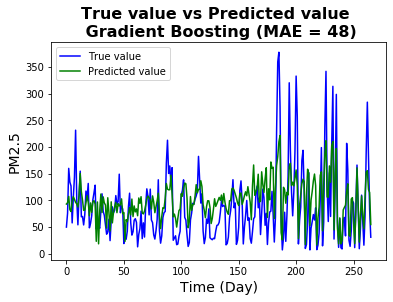

In [521]:
t = [i for i in range(len(PRED_TREE ))]
plt.plot(t,TRUE, 'b-', label='True value')
plt.plot(t,PRED_TREE, 'g-', label='Predicted value')
plt.title('True value vs Predicted value \n Gradient Boosting (MAE = 48)', fontweight = 'bold',fontsize = 16)
plt.xlabel('Time (Day)',fontsize = 14)
plt.ylabel('PM2.5',fontsize = 14)
plt.legend()
plt.show()

### Baseline 2. Densely Connected Network

In [190]:
##Simple & Cheap Deep Learning Model: MLP (Densely Connected Network) 
#1)Architecture of the model
model0 = models.Sequential()
model0.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1]))) 
model0.add(layers.Dense(32, activation='relu')) 
model0.add(layers.Dense(1)) 
model0.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
#2)Train the model 
n = 20 #epochs
history0 = model0.fit_generator(train_gen,
                              steps_per_epoch = 400,
                              epochs = n,
                              validation_data = val_gen,
                              validation_steps = val_steps)

history_dict0 = history0.history

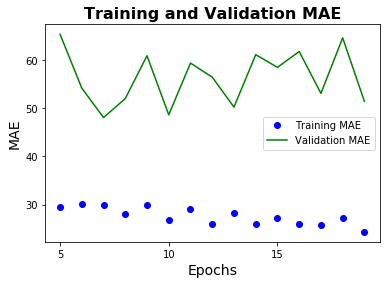

In [75]:
#3)Validation MAE = 60 
##Reaches bottle neck, hypothesis space is not rich to handle the data
epochs = range(5,n,1)
mae0 = [i*std[0] for i in [history_dict0['mean_absolute_error'][i] for i in epochs]]
val_mae0 = [i*std[0] for i in [history_dict0['val_mean_absolute_error'][i] for i in epochs] ]
plt.plot(epochs,mae0, 'bo', label='Training MAE')
plt.plot(epochs,val_mae0, 'g-', label='Validation MAE')
plt.xticks(range(5,n,5))
plt.title('Training and Validation MAE', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('MAE',fontsize = 14)
plt.legend()
plt.show()

In [ ]:
#4)Finalize - retraining the model using whole training set
model0.fit_generator(train_gen2,
                              steps_per_epoch = 500,
                              epochs = 10)

In [88]:
#5)Predicted value v.s. True value
predictions0 = model0.predict_generator(test_gen, steps=test_steps)
predictions0 = predictions0 * std[0] + mean[0]
predictions0 = np.maximum(np.zeros((predictions0.shape[0],1)),predictions0)

In [89]:
PRED0 = DAY_AVG(list(predictions0))

In [ ]:
sum([abs(np.asscalar(TRUE[i]) - np.asscalar(PRED0[i])) for i in range(len(TRUE))])/len(TRUE) #MAE

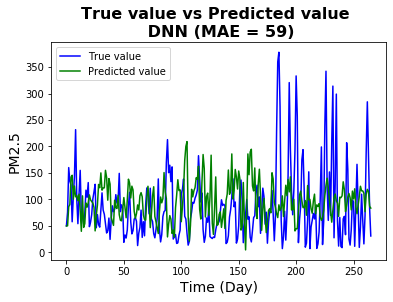

In [91]:
t = [i for i in range(len(PRED0))]
plt.plot(t,TRUE, 'b-', label='True value')
plt.plot(t,PRED0, 'g-', label='Predicted value')
plt.title('True value vs Predicted value \n DNN (MAE = 59)', fontweight = 'bold',fontsize = 16)
plt.xlabel('Time (Day)',fontsize = 14)
plt.ylabel('PM2.5',fontsize = 14)
plt.legend()
plt.show()

## Section 5. Simple RNN

In [206]:
##Single Layer
#1)Architecture of the model
model1 = models.Sequential()
model1.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]))) #(None, 11) - Only 1 recurrent layer
model1.add(layers.Dense(1))
model1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
#2)Train the model 
n = 20 #epochs
history1 = model.fit_generator(train_gen,
                              steps_per_epoch = 200,
                              epochs = n,
                              validation_data = val_gen,
                              validation_steps = val_steps)

history_dict1 = history1.history

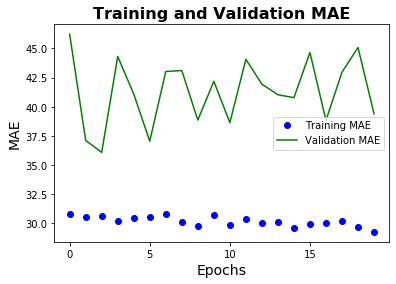

In [685]:
#3) Performance is much better than Gradient Boosting and DNN, but overfitting
mae1 = [i*std[0] for i in [history_dict1['mean_absolute_error'][i] for i in epochs]]
val_mae1 = [i*std[0] for i in [history_dict1['val_mean_absolute_error'][i] for i in epochs]]
plt.plot(epochs,mae1, 'bo', label='Training MAE')
plt.plot(epochs,val_mae1, 'g-', label='Validation MAE')
plt.xticks(range(0,n,5))
plt.title('Training and Validation MAE', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('MAE',fontsize = 14)
plt.legend()
plt.show()

In [ ]:
#4)Finalize - retraining the model using whole training set
model1.fit_generator(train_gen2,
                              steps_per_epoch = 400,
                              epochs = 10)

In [106]:
#5)Predicted value v.s. True value
prediction1 = model1.predict_generator(test_gen, steps=test_steps)
prediction1 = prediction1 * std[0] + mean[0]
prediction1 = np.maximum(np.zeros((prediction1.shape[0],1)),prediction1)

In [107]:
PRED1 = DAY_AVG(list(prediction1))

In [ ]:
sum([abs(np.asscalar(TRUE[i]) - np.asscalar(PRED1[i])) for i in range(len(TRUE))])/len(TRUE) #MAE

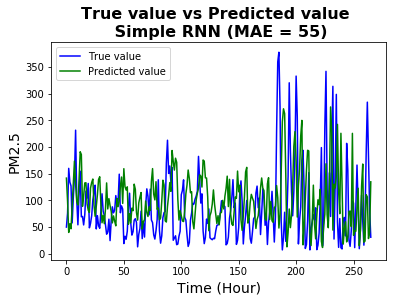

In [110]:
t = [i for i in range(len(PRED1))]
plt.plot(t,TRUE, 'b-', label='True value')
plt.plot(t,PRED1, 'g-', label='Predicted value')
plt.title('True value vs Predicted value \n Simple RNN (MAE = 55)', fontweight = 'bold',fontsize = 16)
plt.xlabel('Time (Hour)',fontsize = 14)
plt.ylabel('PM2.5',fontsize = 14)
plt.legend()
plt.show()

## Section 6. Simple RNN - Regularization

In [211]:
#1)Architecture of the model
model2 = models.Sequential()
model2.add(layers.GRU(64, 
                      dropout=0.4, #input units
                      recurrent_dropout=0.4, #recurrent units
                      input_shape=(None, float_data.shape[-1]))) #(None, 11) - Only 1 recurrent layer
model2.add(layers.Dense(1))
model2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
#2)Train the model 
n = 30 #more epochs as take longer time to converge
history2 = model2.fit_generator(train_gen,
                              steps_per_epoch = 400,
                              epochs = n,
                              validation_data = val_gen,
                              validation_steps = val_steps)

history_dict2 = history2.history

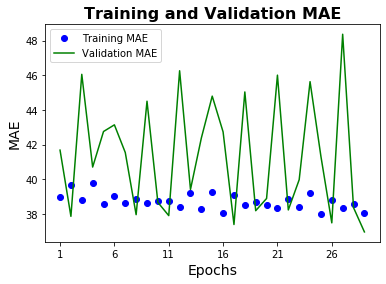

In [79]:
#3) Regularization - more stable validation scores
##Next step: no overfitting -> increasing capacity of the model 
epochs2 = range(1,30,1)
mae2 = [i*std[0] for i in [history_dict2['mean_absolute_error'][i] for i in epochs2]]
val_mae2 = [i*std[0] for i in [history_dict2['val_mean_absolute_error'][i] for i in epochs2] ]
plt.plot(epochs2,mae2, 'bo', label='Training MAE')
plt.plot(epochs2,val_mae2, 'g-', label='Validation MAE')
plt.xticks(range(1,n,5))
plt.title('Training and Validation MAE', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('MAE',fontsize = 14)
plt.legend()
plt.show()

In [ ]:
#4)Finalize - retraining the model using whole training set
model2.fit_generator(train_gen2,
                              steps_per_epoch = 400,
                              epochs = 24)

In [124]:
#5)Predicted value v.s. True value
prediction2 = model2.predict_generator(test_gen, steps=test_steps)
prediction2 = prediction2 * std[0] + mean[0]
prediction2 = np.maximum(np.zeros((prediction2.shape[0],1)),prediction2)

In [125]:
PRED2 = DAY_AVG(list(prediction2))

In [ ]:
sum([abs(np.asscalar(TRUE[i]) - np.asscalar(PRED2[i])) for i in range(len(TRUE))])/len(TRUE) #MAE

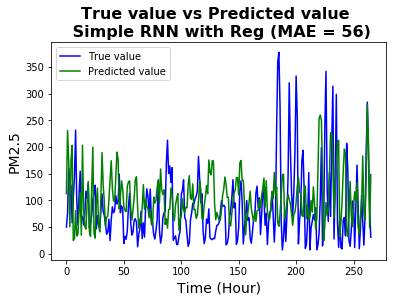

In [128]:
#Plot predicted values vs true values (test set) 
t = [i for i in range(len(PRED2))]
plt.plot(t,TRUE, 'b-', label='True value')
plt.plot(t,PRED2, 'g-', label='Predicted value')
plt.title('True value vs Predicted value \n Simple RNN with Reg (MAE = 56)', fontweight = 'bold',fontsize = 16)
plt.xlabel('Time (Hour)',fontsize = 14)
plt.ylabel('PM2.5',fontsize = 14)
plt.legend()
plt.show()

## Section 7. RNN - Stacked and Regularized

In [780]:
#1)Architecture of the model
model3 = models.Sequential()
model3.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1]))) #Recurrent layer 1
model3.add(layers.GRU(16, activation='relu',
                     dropout=0.2, 
                     recurrent_dropout=0.2)) #Recurrent layer 2
model3.add(layers.Dense(1))
model3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
#2)Train the model 
n = 30 #more epochs as take longer time to converge
history3 = model3.fit_generator(train_gen,
                              steps_per_epoch = 400,
                              epochs = n,
                              validation_data = val_gen,
                              validation_steps = val_steps)

history_dict3 = history3.history

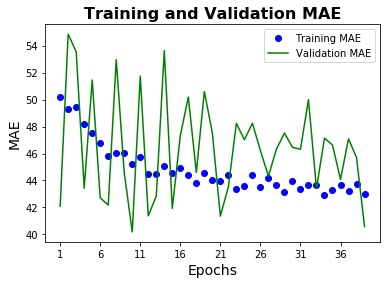

In [713]:
#3) 
epochs3 = range(1,31,1)
mae3 = [i*std[0] for i in [history_dict3['mean_absolute_error'][i] for i in epochs3]]
val_mae3 = [i*std[0] for i in [history_dict3['val_mean_absolute_error'][i] for i in epochs3] ]
plt.plot(epochs3,mae3, 'bo', label='Training MAE')
plt.plot(epochs3,val_mae3, 'g-', label='Validation MAE')
plt.xticks(range(1,31,5))
plt.title('Training and Validation MAE', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('MAE',fontsize = 14)
plt.legend()
plt.show()

In [ ]:
#4)Finalize - retraining the model using whole training set
model3.fit_generator(train_gen2,
                              steps_per_epoch = 500,
                              epochs = 10)

In [131]:
#5) Predicted value v.s. True value
prediction3 = model3.predict_generator(test_gen, steps=test_steps)
prediction3 = prediction3 * std[0] + mean[0]
prediction3 = np.maximum(np.zeros((prediction3.shape[0],1)),prediction3)

In [130]:
PRED3 = DAY_AVG(list(prediction3))

In [133]:
sum([abs(np.asscalar(TRUE[i]) - np.asscalar(PRED3[i])) for i in range(len(TRUE))])/len(TRUE) #MAE

58.22367256386835

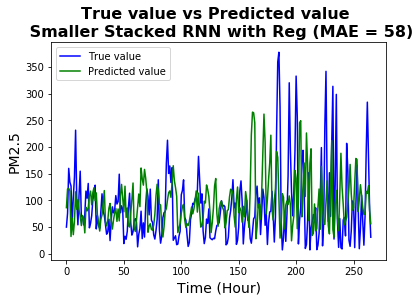

In [134]:
#Plot predicted values vs true values (test set) 
t = [i for i in range(len(PRED3))]
plt.plot(t,TRUE, 'b-', label='True value')
plt.plot(t,PRED3, 'g-', label='Predicted value')
plt.title('True value vs Predicted value \n Smaller Stacked RNN with Reg (MAE = 58)', fontweight = 'bold',fontsize = 16)
plt.xlabel('Time (Hour)',fontsize = 14)
plt.ylabel('PM2.5',fontsize = 14)
plt.legend()
plt.show()

## Section 8 RNN - Stacked (no regularization)

In [748]:
#1)Architecture of the model
model4 = models.Sequential()
model4.add(layers.GRU(64,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1]))) #Recurrent layer 1
model4.add(layers.GRU(32, activation='relu')) #Recurrent layer 2
model4.add(layers.Dense(1))
model4.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
#2)Train the model 
n = 30 #more epochs as take longer time to converge
history4 = model4.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = n,
                              validation_data = val_gen,
                              validation_steps = val_steps)

history_dict4 = history4.history

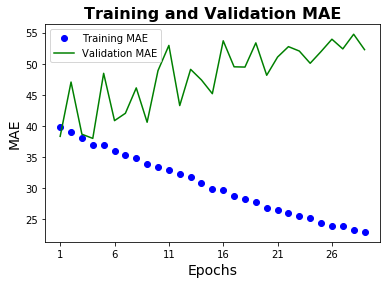

In [762]:
#3) 
epochs4 = range(1,30,1)
mae4 = [i*std[0] for i in [history_dict4['mean_absolute_error'][i] for i in epochs4]]
val_mae4 = [i*std[0] for i in [history_dict4['val_mean_absolute_error'][i] for i in epochs4] ]
plt.plot(epochs4,mae4, 'bo', label='Training MAE')
plt.plot(epochs4,val_mae4, 'g-', label='Validation MAE')
plt.xticks(range(1,30,5))
plt.title('Training and Validation MAE', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('MAE',fontsize = 14)
plt.legend()
plt.show()

In [ ]:
#4)Finalize - retraining the model using whole training set
model4.fit_generator(train_gen2,
                              steps_per_epoch = 500,
                              epochs = 5)

In [135]:
#5)Predicted value v.s. True value
prediction4 = model4.predict_generator(test_gen, steps=test_steps)
prediction4 = prediction4 * std[0] + mean[0]
prediction4 = np.maximum(np.zeros((prediction4.shape[0],1)),prediction4)

In [136]:
PRED4 = DAY_AVG(list(prediction4))

In [ ]:
sum([abs(np.asscalar(TRUE[i]) - np.asscalar(PRED4[i])) for i in range(len(TRUE))])/len(TRUE) #MAE

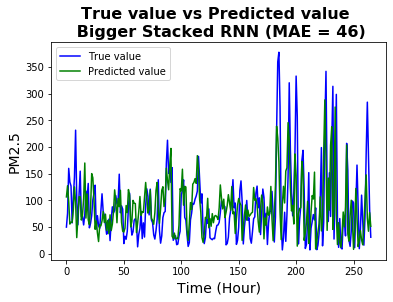

In [411]:
#Plot predicted values vs true values (test set) 
t = [i for i in range(len(PRED4))]
plt.plot(t,TRUE, 'b-', label='True value')
plt.plot(t,PRED4, 'g-', label='Predicted value')
plt.title('True value vs Predicted value \n Bigger Stacked RNN (MAE = 46)', fontweight = 'bold',fontsize = 16)
plt.xlabel('Time (Hour)',fontsize = 14)
plt.ylabel('PM2.5',fontsize = 14)
plt.legend()
plt.show()

## Section 9. 1D CNN - RNN

In [38]:
#1)Architecture of the model - Runs much faster by the 1D CNN Pre-processing
model5 = models.Sequential()
model5.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model5.add(layers.MaxPooling1D(5))
model5.add(layers.GRU(64,
                     return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.5))
model5.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.5))
model5.add(layers.Dense(1))

model5.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [ ]:
#2)Train the model 
n = 20 #more epochs as take longer time to converge
history5 = model5.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = n,
                              validation_data = val_gen,
                              validation_steps = val_steps)

history_dict5 = history5.history

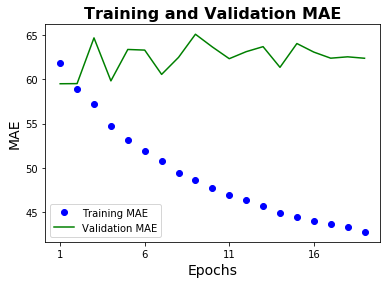

In [40]:
#3) 
epochs5 = range(1,20,1)
mae5 = [i*std[0] for i in [history_dict5['mean_absolute_error'][i] for i in epochs5]]
val_mae5 = [i*std[0] for i in [history_dict5['val_mean_absolute_error'][i] for i in epochs5] ]
plt.plot(epochs5,mae5, 'bo', label='Training MAE')
plt.plot(epochs5,val_mae5, 'g-', label='Validation MAE')
plt.xticks(range(1,20,5))
plt.title('Training and Validation MAE', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('MAE',fontsize = 14)
plt.legend()
plt.show()

In [55]:
#4)Finalize - retraining the model using whole training set
model5.fit_generator(train_gen2,
                              steps_per_epoch = 500,
                              epochs = 4)

Epoch 1/4
500/500 [==============================] - 116s 232ms/step - loss: 0.4089 - mean_absolute_error: 0.4767
Epoch 2/4
500/500 [==============================] - 109s 219ms/step - loss: 0.4016 - mean_absolute_error: 0.4714
Epoch 3/4
500/500 [==============================] - 112s 225ms/step - loss: 0.3998 - mean_absolute_error: 0.4702
Epoch 4/4
500/500 [==============================] - 115s 230ms/step - loss: 0.3943 - mean_absolute_error: 0.4678


In [138]:
#5)Predicted value v.s. True value
prediction5 = model5.predict_generator(test_gen, steps=test_steps)
prediction5 = prediction5 * std[0] + mean[0]
prediction5 = np.maximum(np.zeros((prediction5.shape[0],1)),prediction5)

In [139]:
PRED5 = DAY_AVG(list(prediction5))

In [140]:
sum([abs(np.asscalar(TRUE[i]) - np.asscalar(PRED5[i])) for i in range(len(TRUE))])/len(TRUE) #MAE

56.04548088350989

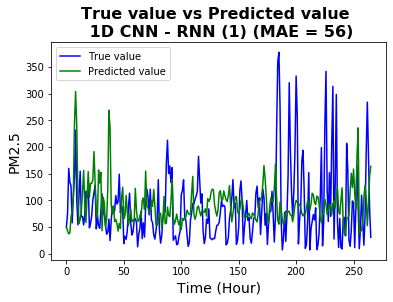

In [141]:
#Plot predicted values vs true values (test set) 
t = [i for i in range(len(PRED5))]
plt.plot(t,TRUE, 'b-', label='True value')
plt.plot(t,PRED5, 'g-', label='Predicted value')
plt.title('True value vs Predicted value \n 1D CNN - RNN (1) (MAE = 56)', fontweight = 'bold',fontsize = 16)
plt.xlabel('Time (Hour)',fontsize = 14)
plt.ylabel('PM2.5',fontsize = 14)
plt.legend()
plt.show()

##  Section 10. 1D CNN - RNN (2)

In [72]:
#1)Architecture of the model - much bigger
model6 = models.Sequential()
model6.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model6.add(layers.MaxPooling1D(3))
model6.add(layers.GRU(128,
                     return_sequences=True,
                     dropout=0.3, 
                    recurrent_dropout=0.5)) #Recurrent layer 1
model6.add(layers.GRU(64, activation='relu',return_sequences=True,dropout=0.3, recurrent_dropout=0.5)) #Recurrent layer 2
model6.add(layers.GRU(32, activation='relu',dropout=0.3, recurrent_dropout=0.5)) #Recurrent layer 3
model6.add(layers.Dense(1))
model6.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [74]:
#2)Train the model 
n = 40 #more epochs as take longer time to converge
history6 = model6.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = n,
                              validation_data = val_gen,
                              validation_steps = val_steps)

history_dict6 = history6.history

Epoch 1/40
500/500 [==============================] - 505s 1s/step - loss: 0.9650 - mean_absolute_error: 0.7488 - val_loss: 0.7470 - val_mean_absolute_error: 0.6743
Epoch 2/40
500/500 [==============================] - 497s 994ms/step - loss: 0.8716 - mean_absolute_error: 0.7185 - val_loss: 0.7718 - val_mean_absolute_error: 0.6907
Epoch 3/40
500/500 [==============================] - 495s 989ms/step - loss: 0.8010 - mean_absolute_error: 0.6890 - val_loss: 0.7848 - val_mean_absolute_error: 0.7045
Epoch 4/40
500/500 [==============================] - 495s 990ms/step - loss: 0.7698 - mean_absolute_error: 0.6715 - val_loss: 0.7631 - val_mean_absolute_error: 0.6775
Epoch 5/40
500/500 [==============================] - 516s 1s/step - loss: 0.7252 - mean_absolute_error: 0.6506 - val_loss: 0.7644 - val_mean_absolute_error: 0.6705
Epoch 6/40
500/500 [==============================] - 495s 990ms/step - loss: 0.6937 - mean_absolute_error: 0.6370 - val_loss: 0.7899 - val_mean_absolute_error: 0.682

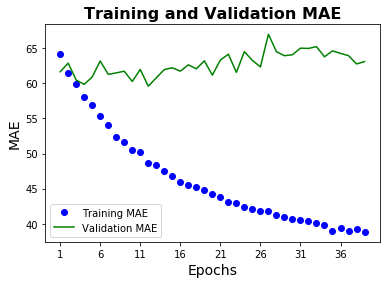

In [75]:
#3) 
epochs6 = range(1,40,1)
mae6 = [i*std[0] for i in [history_dict6['mean_absolute_error'][i] for i in epochs6]]
val_mae6 = [i*std[0] for i in [history_dict6['val_mean_absolute_error'][i] for i in epochs6] ]
plt.plot(epochs6,mae6, 'bo', label='Training MAE')
plt.plot(epochs6,val_mae6, 'g-', label='Validation MAE')
plt.xticks(range(1,40,5))
plt.title('Training and Validation MAE', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('MAE',fontsize = 14)
plt.legend()
plt.show()

In [77]:
#4)Finalize - retraining the model using whole training set
model6.fit_generator(train_gen2,
                              steps_per_epoch = 500,
                              epochs = 12)

Epoch 1/12
500/500 [==============================] - 491s 981ms/step - loss: 0.5065 - mean_absolute_error: 0.5088
Epoch 2/12
500/500 [==============================] - 487s 973ms/step - loss: 0.4619 - mean_absolute_error: 0.4949
Epoch 3/12
500/500 [==============================] - 484s 968ms/step - loss: 0.4554 - mean_absolute_error: 0.4924
Epoch 4/12
500/500 [==============================] - 487s 973ms/step - loss: 0.4365 - mean_absolute_error: 0.4830
Epoch 5/12
500/500 [==============================] - 484s 967ms/step - loss: 0.4256 - mean_absolute_error: 0.4815
Epoch 6/12
500/500 [==============================] - 485s 969ms/step - loss: 0.4182 - mean_absolute_error: 0.4765
Epoch 7/12
500/500 [==============================] - 483s 966ms/step - loss: 0.4151 - mean_absolute_error: 0.4746
Epoch 8/12
500/500 [==============================] - 486s 972ms/step - loss: 0.4079 - mean_absolute_error: 0.4688
Epoch 9/12
500/500 [==============================] - 484s 969ms/step - loss: 0.

In [78]:
#5)Predicted value v.s. True value
prediction6 = model6.predict_generator(test_gen, steps=test_steps)
prediction6 = prediction6 * std[0] + mean[0]
prediction6 = np.maximum(np.zeros((prediction6.shape[0],1)),prediction6)

In [79]:
PRED6 = DAY_AVG(list(prediction6))

In [80]:
sum([abs(np.asscalar(TRUE[i]) - np.asscalar(PRED6[i])) for i in range(len(TRUE))])/len(TRUE) #MAE

51.18440909552993

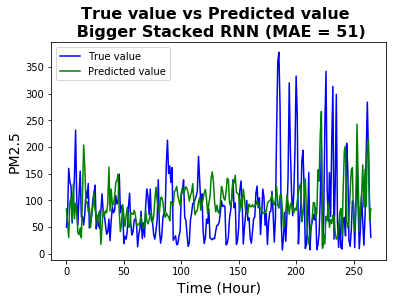

In [81]:
#Plot predicted values vs true values (test set) 
t = [i for i in range(len(PRED6))]
plt.plot(t,TRUE, 'b-', label='True value')
plt.plot(t,PRED5, 'g-', label='Predicted value')
plt.title('True value vs Predicted value \n Bigger Stacked RNN (MAE = 51)', fontweight = 'bold',fontsize = 16)
plt.xlabel('Time (Hour)',fontsize = 14)
plt.ylabel('PM2.5',fontsize = 14)
plt.legend()
plt.show()

## Appendix

In [86]:
#Save the models
from keras.models import load_model
#model0.save('model0.h5')
#model1.save('model1.h5')
#model2.save('model2.h5')
#model3.save('model3.h5')
#model4.save('model4.h5')
#model5.save('model5.h5')
#model6.save('model5.h5')

In [119]:
#Load the models
#model0 = load_model('model0.h5')
#model1 = load_model('model1.h5')
#model2 = load_model('model2.h5')
#model3 = load_model('model3.h5')
#model4 = load_model('model4.h5')
#model5 = load_model('model5.h5')
#model6 = load_model('model6.h5')

# Model Summary

In [65]:
print(model0.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3960)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                126752    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 126,785
Trainable params: 126,785
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_38 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_63 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_61 (GRU)                 (None, None, 32)          4224      
_________________________________________________________________
gru_62 (GRU)                 (None, 16)                2352      
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 17        
Total params: 6,593
Trainable params: 6,593
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
print(model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_55 (GRU)                 (None, None, 64)          14592     
_________________________________________________________________
gru_56 (GRU)                 (None, 32)                9312      
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 33        
Total params: 23,937
Trainable params: 23,937
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
print(model5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          1792      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
gru_13 (GRU)                 (None, None, 64)          18624     
_________________________________________________________________
gru_14 (GRU)                 (None, 32)                9312      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 29,761
Trainable params: 29,761
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
print(model6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, None, 32)          1792      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
gru_22 (GRU)                 (None, None, 128)         61824     
_________________________________________________________________
gru_23 (GRU)                 (None, None, 64)          37056     
_________________________________________________________________
gru_24 (GRU)                 (None, 32)                9312      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 110,017
Trainable params: 110,017
Non-trainable params: 0
_________________________________________________________________
None